In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm
import h5py
from itertools import cycle

import DLlib as dl
import pylib as py
import tf2lib as tl
import tf2gan as gan
import wflib as wf
# import falib as fa

import data

In [2]:
dataset_dir = '../MRI-Datasets/'
dataset_hdf5_2 = 'UNet-INTA/INTA_GC_192_complex_2D.hdf5'
# dataset_hdf5_2 = 'UNet-phantom/phantom_GC_192_complex_2D.hdf5'

valX, valY = data.load_hdf5(dataset_dir,dataset_hdf5_2, ech_idx=12, complex_data=False)

valX = valX[12::22,:,:,:] #15::20
valY = valY[12::22,:,:,:] #15::20

print('Num. Elements- DS2:', len(valX))

# Overall dataset statistics
len_dataset,hgt,wdt,d_ech = np.shape(valX)
_,_,_,n_out = np.shape(valY)
echoes = int(d_ech/2)

print('Validation input shape:',valX.shape)
print('Validation output shape:',valY.shape)

A_B_dataset_val = tf.data.Dataset.from_tensor_slices((valX,valY))
val_iter = cycle(A_B_dataset_val)

Num. Elements- DS2: 17
Validation input shape: (17, 192, 192, 12)
Validation output shape: (17, 192, 192, 6)


In [3]:
@tf.function
def sample(A,B,TE=None,complex_data=False):
    indx_B = tf.concat([tf.zeros_like(B[:,:,:,:4],dtype=tf.int32),
                        tf.ones_like(B[:,:,:,:2],dtype=tf.int32)],axis=-1)
    B_WF,B_PM = tf.dynamic_partition(B,indx_B,num_partitions=2)
    B_PM = tf.reshape(B_PM,B[:,:,:,4:].shape)
    A2B_PM = B_PM
    if TE is not(None):
        te_orig = wf.gen_TEvar(echoes,1,orig=True)
        A = wf.acq_add_te(A,B,te_orig,TE,complex_data)
    A2B_WF, A2B2A = wf.acq_to_acq(A,A2B_PM,TE,complex_data=complex_data)
    A2B = tf.concat([A2B_WF,A2B_PM],axis=-1)
    B2A = wf.IDEAL_model(B,6,TE,complex_data=complex_data)
    return A, A2B, B2A, A2B2A

In [ ]:
A, B = next(val_iter)
A = tf.expand_dims(A[::4,::4,:],axis=0)
B = tf.expand_dims(B[::4,::4,:],axis=0)

te_var = wf.gen_TEvar(echoes,1)
te_orig = wf.gen_TEvar(echoes,1,orig=True)
dte = te_var - te_orig
print('dte:',dte.shape)

###################################################
############## IDEAL model variables ##############
###################################################

# Multipeak fat model
species = ["water", "fat"]
ns = len(species)
field = 1.5

f_p = np.array([ 0., -3.80, -3.40, -2.60, -1.94, -0.39, 0.60 ]) * 1E-6 * 42.58E6 * field
f_p = tf.convert_to_tensor(f_p,dtype=tf.complex64)
f_p = tf.expand_dims(f_p,0)

A_p = np.array([[1.0,0.0],[0.0,0.087],[0.0,0.693],[0.0,0.128],[0.0,0.004],[0.0,0.039],[0.0,0.048]])
A_p = tf.convert_to_tensor(A_p,dtype=tf.complex64)

r2_sc = 200.0   # HR:150 / GC:200
fm_sc = 300.0   # HR:300 / GC:400
rho_sc = 1.4

###################################################
###################################################

n_batch,hgt_c,wdt_c,d_ech = A.shape
n_ech = d_ech//2

dte = tf.cast(dte,tf.complex64)
dte = tf.expand_dims(dte,-1)
ne = len(dte[0])

# Generate complex signal
real_S = A[:,:,:,0::2]
imag_S = A[:,:,:,1::2]
S = tf.complex(real_S,imag_S)

voxel_shape = tf.convert_to_tensor((hgt_c,wdt_c))
num_voxel = tf.math.reduce_prod(voxel_shape)
Smtx = tf.transpose(tf.reshape(S, [n_batch, num_voxel, ne]), perm=[0,2,1]) # shape: (bs,nv,ne)
print('Smtx:',Smtx.shape)

# Graph-Cuts results
orig_rho = B[:,:,:,:4]
param_maps = B[:,:,:,4:]

# IDEAL Operator evaluation for xi = phi + 1j*r2s/(2*np.pi)
r2s = param_maps[:,:,:,0] * r2_sc
phi = param_maps[:,:,:,1] * fm_sc
xi = tf.complex(phi,r2s/(2*np.pi))
xi_rav = tf.reshape(xi,[n_batch,-1])
xi_rav = tf.expand_dims(xi_rav,1)

# Generate complex water/fat signals
real_rho = orig_rho[:,:,:,0::2]
imag_rho = orig_rho[:,:,:,1::2]
rho = tf.complex(real_rho,imag_rho) * rho_sc

voxel_shape = tf.convert_to_tensor((hgt_c,wdt_c))
num_voxel = tf.math.reduce_prod(voxel_shape)
rho_mtx = tf.transpose(tf.reshape(rho, [n_batch, num_voxel, ns]), perm=[0,2,1])

Arho = tf.linalg.matmul(A_p,rho_mtx)
print('Arho:',Arho.shape)


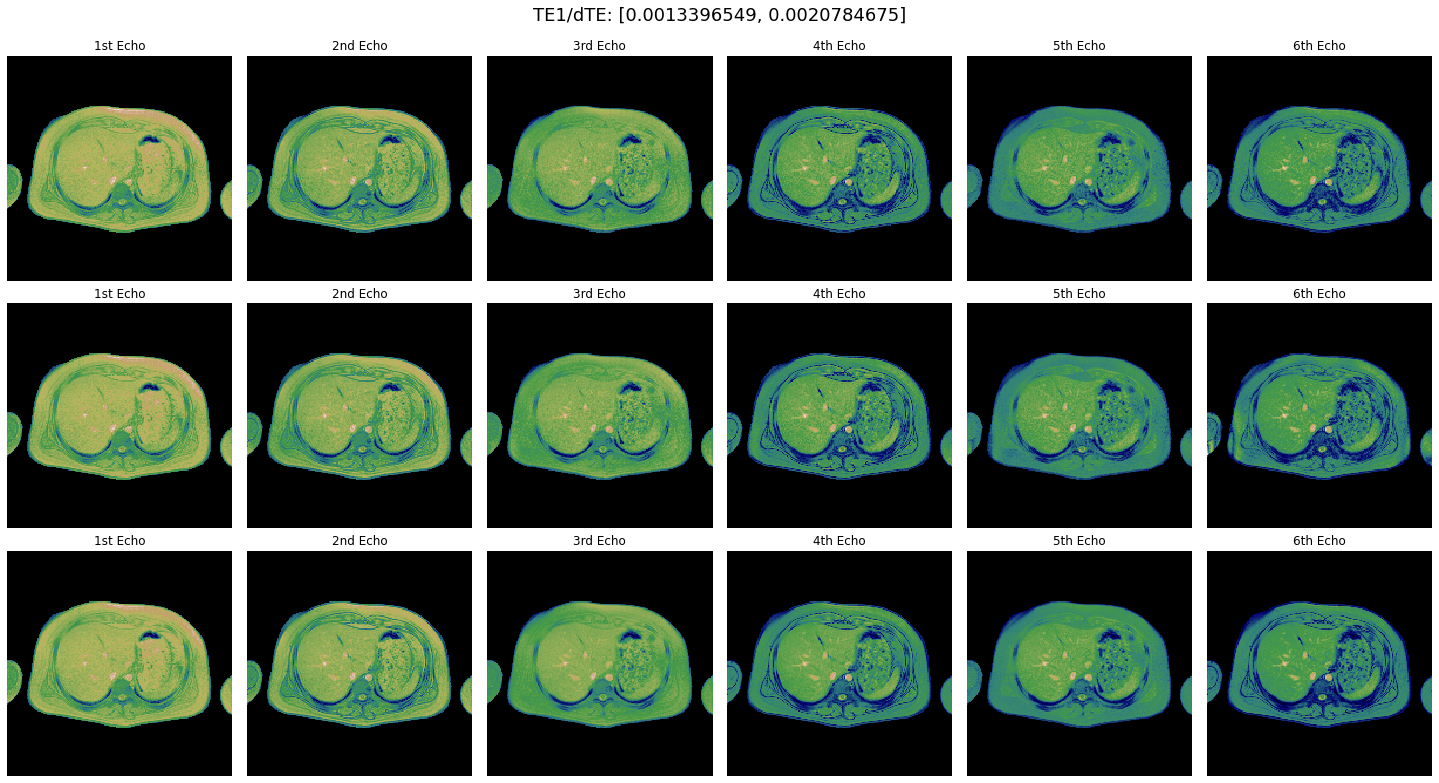

In [4]:
complex_data = False

A, B = next(val_iter)
A = tf.expand_dims(A,axis=0)
B = tf.expand_dims(B,axis=0)
te_var = wf.gen_TEvar(echoes,1)
A_mod, A2B, B2A, A2B2A = sample(A,B,te_var)
# A_mod, A2B, B2A, A2B2A = sample(A,B,complex_data=complex_data)

fig_end, dx = plt.subplots(figsize=(20, 10),nrows=3,ncols=6)

# Magnitude of recon MR images at each echo
if not(complex_data):
    im_ech1 = np.squeeze(np.abs(tf.complex(A[:,:,:,0],A[:,:,:,1])))
    im_ech2 = np.squeeze(np.abs(tf.complex(A[:,:,:,2],A[:,:,:,3])))
    im_ech3 = np.squeeze(np.abs(tf.complex(A[:,:,:,4],A[:,:,:,5])))
    im_ech4 = np.squeeze(np.abs(tf.complex(A[:,:,:,6],A[:,:,:,7])))
    im_ech5 = np.squeeze(np.abs(tf.complex(A[:,:,:,8],A[:,:,:,9])))
    im_ech6 = np.squeeze(np.abs(tf.complex(A[:,:,:,10],A[:,:,:,11])))
    
    sim_ech1 = np.squeeze(np.abs(tf.complex(A_mod[:,:,:,0],A_mod[:,:,:,1])))
    sim_ech2 = np.squeeze(np.abs(tf.complex(A_mod[:,:,:,2],A_mod[:,:,:,3])))
    sim_ech3 = np.squeeze(np.abs(tf.complex(A_mod[:,:,:,4],A_mod[:,:,:,5])))
    sim_ech4 = np.squeeze(np.abs(tf.complex(A_mod[:,:,:,6],A_mod[:,:,:,7])))
    sim_ech5 = np.squeeze(np.abs(tf.complex(A_mod[:,:,:,8],A_mod[:,:,:,9])))
    sim_ech6 = np.squeeze(np.abs(tf.complex(A_mod[:,:,:,10],A_mod[:,:,:,11])))
    
    rim_ech1 = np.squeeze(np.abs(tf.complex(B2A[:,:,:,0],B2A[:,:,:,1])))
    rim_ech2 = np.squeeze(np.abs(tf.complex(B2A[:,:,:,2],B2A[:,:,:,3])))
    rim_ech3 = np.squeeze(np.abs(tf.complex(B2A[:,:,:,4],B2A[:,:,:,5])))
    rim_ech4 = np.squeeze(np.abs(tf.complex(B2A[:,:,:,6],B2A[:,:,:,7])))
    rim_ech5 = np.squeeze(np.abs(tf.complex(B2A[:,:,:,8],B2A[:,:,:,9])))
    rim_ech6 = np.squeeze(np.abs(tf.complex(B2A[:,:,:,10],B2A[:,:,:,11])))
else:
    im_ech1 = np.squeeze(np.abs(A[:,:,:,0]))
    im_ech2 = np.squeeze(np.abs(A[:,:,:,1]))
    im_ech3 = np.squeeze(np.abs(A[:,:,:,2]))
    im_ech4 = np.squeeze(np.abs(A[:,:,:,3]))
    im_ech5 = np.squeeze(np.abs(A[:,:,:,4]))
    im_ech6 = np.squeeze(np.abs(A[:,:,:,5]))
    
    sim_ech1 = np.squeeze(np.abs(A_mod[:,:,:,0]))
    sim_ech2 = np.squeeze(np.abs(A_mod[:,:,:,1]))
    sim_ech3 = np.squeeze(np.abs(A_mod[:,:,:,2]))
    sim_ech4 = np.squeeze(np.abs(A_mod[:,:,:,3]))
    sim_ech5 = np.squeeze(np.abs(A_mod[:,:,:,4]))
    sim_ech6 = np.squeeze(np.abs(A_mod[:,:,:,5]))
    
    rim_ech1 = np.squeeze(np.abs(B2A[:,:,:,0]))
    rim_ech2 = np.squeeze(np.abs(B2A[:,:,:,1]))
    rim_ech3 = np.squeeze(np.abs(B2A[:,:,:,2]))
    rim_ech4 = np.squeeze(np.abs(B2A[:,:,:,3]))
    rim_ech5 = np.squeeze(np.abs(B2A[:,:,:,4]))
    rim_ech6 = np.squeeze(np.abs(B2A[:,:,:,5]))

# Acquisitions in the first row
acq_ech1 = dx[0,0].imshow(im_ech1, cmap='gist_earth',
                          interpolation='none', vmin=0, vmax=1)
dx[0,0].set_title('1st Echo')
dx[0,0].axis('off')
acq_ech2 = dx[0,1].imshow(im_ech2, cmap='gist_earth',
                          interpolation='none', vmin=0, vmax=1)
dx[0,1].set_title('2nd Echo')
dx[0,1].axis('off')
acq_ech3 = dx[0,2].imshow(im_ech3, cmap='gist_earth',
                          interpolation='none', vmin=0, vmax=1)
dx[0,2].set_title('3rd Echo')
dx[0,2].axis('off')
acq_ech4 = dx[0,3].imshow(im_ech4, cmap='gist_earth',
                          interpolation='none', vmin=0, vmax=1)
dx[0,3].set_title('4th Echo')
dx[0,3].axis('off')
acq_ech5 = dx[0,4].imshow(im_ech5, cmap='gist_earth',
                          interpolation='none', vmin=0, vmax=1)
dx[0,4].set_title('5th Echo')
dx[0,4].axis('off')
acq_ech6 = dx[0,5].imshow(im_ech6, cmap='gist_earth',
                          interpolation='none', vmin=0, vmax=1)
dx[0,5].set_title('6th Echo')
dx[0,5].axis('off')

# B2A acquisitions (signal model) on the second row
sacq_ech1 = dx[1,0].imshow(sim_ech1, cmap='gist_earth',
                           interpolation='none', vmin=0, vmax=1)
dx[1,0].set_title('1st Echo')
dx[1,0].axis('off')
sacq_ech2 = dx[1,1].imshow(sim_ech2, cmap='gist_earth',
                           interpolation='none', vmin=0, vmax=1)
dx[1,1].set_title('2nd Echo')
dx[1,1].axis('off')
sacq_ech3 = dx[1,2].imshow(sim_ech3, cmap='gist_earth',
                           interpolation='none', vmin=0, vmax=1)
dx[1,2].set_title('3rd Echo')
dx[1,2].axis('off')
sacq_ech4 = dx[1,3].imshow(sim_ech4, cmap='gist_earth',
                           interpolation='none', vmin=0, vmax=1)
dx[1,3].set_title('4th Echo')
dx[1,3].axis('off')
sacq_ech5 = dx[1,4].imshow(sim_ech5, cmap='gist_earth',
                           interpolation='none', vmin=0, vmax=1)
dx[1,4].set_title('5th Echo')
dx[1,4].axis('off')
sacq_ech6 = dx[1,5].imshow(sim_ech6, cmap='gist_earth',
                           interpolation='none', vmin=0, vmax=1)
dx[1,5].set_title('6th Echo')
dx[1,5].axis('off')

# A2B2A acquisitions (with xi + signal model) on the third row
racq_ech1 = dx[2,0].imshow(rim_ech1, cmap='gist_earth',
                           interpolation='none', vmin=0, vmax=1)
dx[2,0].set_title('1st Echo')
dx[2,0].axis('off')
racq_ech2 = dx[2,1].imshow(rim_ech2, cmap='gist_earth',
                           interpolation='none', vmin=0, vmax=1)
dx[2,1].set_title('2nd Echo')
dx[2,1].axis('off')
racq_ech3 = dx[2,2].imshow(rim_ech3, cmap='gist_earth',
                           interpolation='none', vmin=0, vmax=1)
dx[2,2].set_title('3rd Echo')
dx[2,2].axis('off')
racq_ech4 = dx[2,3].imshow(rim_ech4, cmap='gist_earth',
                        interpolation='none', vmin=0, vmax=1)
dx[2,3].set_title('4th Echo')
dx[2,3].axis('off')
racq_ech5 = dx[2,4].imshow(rim_ech5, cmap='gist_earth',
                           interpolation='none', vmin=0, vmax=1)
dx[2,4].set_title('5th Echo')
dx[2,4].axis('off')
racq_ech6 = dx[2,5].imshow(rim_ech6, cmap='gist_earth',
                        interpolation='none', vmin=0, vmax=1)
dx[2,5].set_title('6th Echo')
dx[2,5].axis('off')

fig_end.suptitle('TE1/dTE: '+str([te_var[0,0].numpy(),np.mean(np.diff(te_var))]), fontsize=18)
plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
tl.make_space_above(dx,topmargin=0.9)

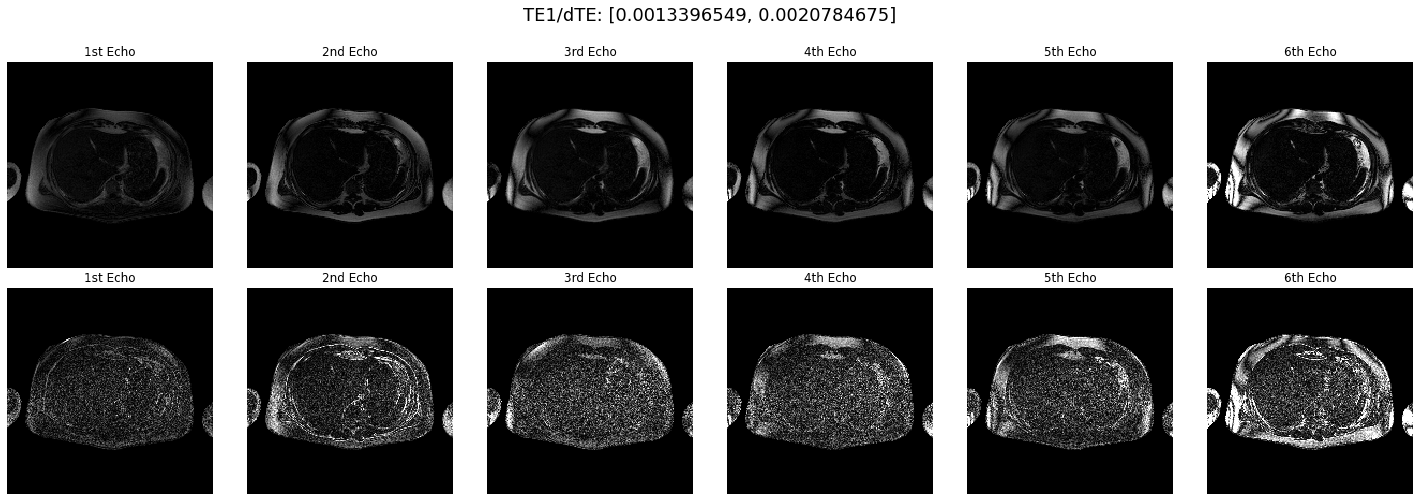

In [5]:
fig_err, ex = plt.subplots(figsize=(20, 6),nrows=2,ncols=6)

# B2A acquisitions (signal model) error on the first row
err_sacq_ech1 = ex[0,0].imshow(np.abs(sim_ech1-im_ech1), cmap='gist_gray',
                               interpolation='none', vmin=0, vmax=.1)
ex[0,0].set_title('1st Echo')
ex[0,0].axis('off')
err_sacq_ech2 = ex[0,1].imshow(np.abs(sim_ech2-im_ech2), cmap='gist_gray',
                               interpolation='none', vmin=0, vmax=.1)
ex[0,1].set_title('2nd Echo')
ex[0,1].axis('off')
err_sacq_ech3 = ex[0,2].imshow(np.abs(sim_ech3-im_ech3), cmap='gist_gray',
                               interpolation='none', vmin=0, vmax=.1)
ex[0,2].set_title('3rd Echo')
ex[0,2].axis('off')
err_sacq_ech4 = ex[0,3].imshow(np.abs(sim_ech4-im_ech4), cmap='gist_gray',
                               interpolation='none', vmin=0, vmax=.1)
ex[0,3].set_title('4th Echo')
ex[0,3].axis('off')
err_sacq_ech5 = ex[0,4].imshow(np.abs(sim_ech5-im_ech5), cmap='gist_gray',
                               interpolation='none', vmin=0, vmax=.1)
ex[0,4].set_title('5th Echo')
ex[0,4].axis('off')
err_sacq_ech6 = ex[0,5].imshow(np.abs(sim_ech6-im_ech6), cmap='gist_gray',
                               interpolation='none', vmin=0, vmax=.1)
ex[0,5].set_title('6th Echo')
ex[0,5].axis('off')

# A2B2A acquisitions (with xi + signal model) error on the second row
err_racq_ech1 = ex[1,0].imshow(np.abs(rim_ech1-sim_ech1), cmap='gist_gray',
                               interpolation='none', vmin=0, vmax=.1)
ex[1,0].set_title('1st Echo')
ex[1,0].axis('off')
err_racq_ech2 = ex[1,1].imshow(np.abs(rim_ech2-sim_ech2), cmap='gist_gray',
                               interpolation='none', vmin=0, vmax=.1)
ex[1,1].set_title('2nd Echo')
ex[1,1].axis('off')
err_racq_ech3 = ex[1,2].imshow(np.abs(rim_ech3-sim_ech3), cmap='gist_gray',
                               interpolation='none', vmin=0, vmax=.1)
ex[1,2].set_title('3rd Echo')
ex[1,2].axis('off')
err_racq_ech4 = ex[1,3].imshow(np.abs(rim_ech4-sim_ech4), cmap='gist_gray',
                               interpolation='none', vmin=0, vmax=.1)
ex[1,3].set_title('4th Echo')
ex[1,3].axis('off')
err_racq_ech5 = ex[1,4].imshow(np.abs(rim_ech5-sim_ech5), cmap='gist_gray',
                               interpolation='none', vmin=0, vmax=.1)
ex[1,4].set_title('5th Echo')
ex[1,4].axis('off')
err_racq_ech6 = ex[1,5].imshow(np.abs(rim_ech6-sim_ech6), cmap='gist_gray',
                               interpolation='none', vmin=0, vmax=.1)
ex[1,5].set_title('6th Echo')
ex[1,5].axis('off')

fig_err.suptitle('TE1/dTE: '+str([te_var[0,0].numpy(),np.mean(np.diff(te_var))]), fontsize=18)
plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
tl.make_space_above(ex,topmargin=0.9)

In [ ]:
r2_sc,fm_sc = 200.0,300.0

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8))=plt.subplots(figsize=(14, 6),nrows=2,ncols=4)
# Ground truth in the first row
w_aux = np.squeeze(np.abs(tf.complex(A2B[:,:,:,0],A2B[:,:,:,1])))
W_ok = ax1.imshow(w_aux, cmap='bone',
                  interpolation='none', vmin=0, vmax=1)
fig.colorbar(W_ok, ax=ax1)
ax1.axis('off')

f_aux = np.squeeze(np.abs(tf.complex(A2B[:,:,:,2],A2B[:,:,:,3])))
F_ok = ax2.imshow(f_aux, cmap='pink',
                  interpolation='none', vmin=0, vmax=1)
fig.colorbar(F_ok, ax=ax2)
ax2.axis('off')

r2_aux = np.squeeze(A2B[:,:,:,4])
r2_ok = ax3.imshow(r2_aux*r2_sc, cmap='copper',
                   interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_ok, ax=ax3)
ax3.axis('off')

field_aux = np.squeeze(A2B[:,:,:,5])
field_ok = ax4.imshow(field_aux*fm_sc, cmap='twilight',
                      interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
fig.colorbar(field_ok, ax=ax4)
ax4.axis('off')

# Computed maps in the second row
wn_aux = np.squeeze(np.abs(tf.complex(B[:,:,:,0],B[:,:,:,1])))
W_unet = ax5.imshow(wn_aux, cmap='bone',
                    interpolation='none', vmin=0, vmax=1)
fig.colorbar(W_unet, ax=ax5)
ax5.axis('off')

fn_aux = np.squeeze(np.abs(tf.complex(B[:,:,:,2],B[:,:,:,3])))
F_unet = ax6.imshow(fn_aux, cmap='pink',
                    interpolation='none', vmin=0, vmax=1)
fig.colorbar(F_unet, ax=ax6)
ax6.axis('off')

r2n_aux = np.squeeze(B[:,:,:,4])
r2_unet = ax7.imshow(r2n_aux*r2_sc, cmap='copper',
                     interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_unet, ax=ax7)
ax7.axis('off')

fieldn_aux = np.squeeze(B[:,:,:,5])
field_unet = ax8.imshow(fieldn_aux*fm_sc, cmap='twilight',
                        interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
fig.colorbar(field_unet, ax=ax8)
ax8.axis('off')

# plt.show()
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0.1, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

In [ ]:
experiment_dir = 'output/IDEAL-GAN-42'
n_echoes = 6
te_input = False
n_filters = 64
batch_size = 1

G_A2B = module.PM_Generator(input_shape=(hgt,wdt,d_ech),
                            te_input=te_input,
                            te_shape=(n_echoes,),
                            filters=n_filters,
                            R2_self_attention=False,
                            FM_self_attention=True)

# restore
tl.Checkpoint(dict(G_A2B=G_A2B), py.join(experiment_dir, 'checkpoints')).restore()

In [ ]:
@tf.function
def fa_comp(A,B):
    indx_B = tf.concat([tf.zeros_like(B[:,:,:,:4],dtype=tf.int32),
                        tf.ones_like(B[:,:,:,:2],dtype=tf.int32)],axis=-1)
    # Graph Cuts results
    B_WF,B_PM = tf.dynamic_partition(B,indx_B,num_partitions=2)
    B_PM = tf.reshape(B_PM,B[:,:,:,4:].shape)
    # Model results
    A2B_PM = G_A2B(A, training=False)
    A2B_PM = tf.where(A[:,:,:,:2]!=0.0,A2B_PM,0)
    A2B_P = fa.get_rho(A,A2B_PM)
    return A2B_P

In [ ]:
A, B = next(val_iter)
A = tf.expand_dims(A,axis=0)
B = tf.expand_dims(B,axis=0)

A2B_P = fa_comp(A,B)
print(A2B_P[:,:,:,0].shape)

fig_fa, fxs = plt.subplots(figsize=(14, 6),nrows=2,ncols=4)

# Fatty acid decomposition
w_fa_aux = np.squeeze(tf.complex(A2B_P[:,:,:,0],A2B_P[:,:,:,1]))
W_fa = fxs[0,0].imshow(np.abs(w_fa_aux), cmap='bone', interpolation='none', vmin=0, vmax=1)
fig_fa.colorbar(W_fa, ax=fxs[0,0])
fxs[0,0].axis('off')
fxs[0,0].set_title('Water')

f_fa_aux = np.squeeze(tf.complex(A2B_P[:,:,:,2],A2B_P[:,:,:,3]))

ndb_fa_aux = np.squeeze(tf.complex(A2B_P[:,:,:,4],A2B_P[:,:,:,5]))
ndb_fa_aux = ndb_fa_aux/f_fa_aux
ndb_fa_aux[np.isnan(ndb_fa_aux)] = 0.0
NDB_fa = fxs[0,2].imshow(np.real(ndb_fa_aux), cmap='gist_earth', interpolation='none', vmin=0, vmax=5)
fig_fa.colorbar(NDB_fa, ax=fxs[0,2])
fxs[0,2].axis('off')
fxs[0,2].set_title('ndb')

nmidb_fa_aux = np.squeeze(tf.complex(A2B_P[:,:,:,6],A2B_P[:,:,:,7]))
nmidb_fa_aux = nmidb_fa_aux/f_fa_aux
nmidb_fa_aux[np.isnan(nmidb_fa_aux)] = 0.0
NMIDB_fa = fxs[0,3].imshow(np.real(nmidb_fa_aux), cmap='gist_stern', interpolation='none', vmin=0, vmax=3)
fig_fa.colorbar(NMIDB_fa, ax=fxs[0,3])
fxs[0,3].axis('off')
fxs[0,3].set_title('nmidb')

cl_fa_aux = np.squeeze(tf.complex(A2B_P[:,:,:,8],A2B_P[:,:,:,9]))
cl_fa_aux = cl_fa_aux/f_fa_aux
cl_fa_aux[np.isnan(cl_fa_aux)] = 0.0
CL_fa = fxs[0,1].imshow(np.real(cl_fa_aux), cmap='gist_rainbow', interpolation='none', vmin=0, vmax=20)
fig_fa.colorbar(CL_fa, ax=fxs[0,1])
fxs[0,1].axis('off')
fxs[0,1].set_title('cl')

f_map = 1/(6*cl_fa_aux - 2*ndb_fa_aux + 2)
f_map[np.isnan(f_map)] = 0.0
fat_fa_aux = f_fa_aux/f_map
fat_fa_aux[np.isnan(fat_fa_aux)] = 0.0
F_fa = fxs[1,0].imshow(np.abs(fat_fa_aux), cmap='pink', interpolation='none', vmin=0, vmax=1)
fig_fa.colorbar(F_fa, ax=fxs[1,0])
fxs[1,0].axis('off')
fxs[1,0].set_title('Fat')

PDFF_aux = fat_fa_aux/(w_fa_aux+fat_fa_aux)
PDFF_aux[np.isnan(PDFF_aux)] = 0.0
PDFF_fa = fxs[1,1].imshow(np.abs(PDFF_aux), cmap='viridis', interpolation='none', vmin=0, vmax=1)
fig_fa.colorbar(PDFF_fa, ax=fxs[1,1])
fxs[1,1].axis('off')
fxs[1,1].set_title('PDFF')

f_sum = (np.real(ndb_fa_aux) - np.real(nmidb_fa_aux))/3
f_pufa = np.real(nmidb_fa_aux)/3
f_mufa = f_sum - f_pufa

MUFA_fa = fxs[1,2].imshow(f_mufa, cmap='gnuplot', interpolation='none', vmin=0, vmax=1)
fig_fa.colorbar(MUFA_fa, ax=fxs[1,2])
fxs[1,2].axis('off')
fxs[1,2].set_title('MUFA')

PUFA_fa = fxs[1,3].imshow(f_pufa, cmap='gnuplot2', interpolation='none', vmin=0, vmax=1)
fig_fa.colorbar(PUFA_fa, ax=fxs[1,3])
fxs[1,3].axis('off')
fxs[1,3].set_title('PUFA')

plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)